In [5]:
import SimpleITK as sitk
img = sitk.ReadImage('./wd0000_ps_image.nii.gz') #size = 512x512x96, spacing = 1x1x1


print("Image Size: ", img.GetSize())
print("Image Spacing: ", img.GetSpacing())


Image Size:  (512, 512, 254)
Image Spacing:  (0.798828125, 0.798828125, 2.0)


In [6]:
ref = sitk.Image(96, 512,512, sitk.sitkFloat32)
ref.SetOrigin(img.GetOrigin())
ref.SetDirection(img.GetDirection())
spacing = img.GetSpacing() # x,y,z spacing
size = img.GetSize()
spacing_x = spacing[0]*size[0]/96
spacing_y = spacing[1]*size[1]/512
spacing_z = spacing[2]*size[2]/512

ref.SetSpacing((spacing_x,spacing_y,spacing_z))

In [7]:
res = sitk.ResampleImageFilter()
res.SetReferenceImage(ref)
img_resampled = res.Execute(img)

In [8]:
sitk.WriteImage(img_resampled, './resampled.nii.gz')

In [80]:
import SimpleITK as sitk
import time
import albumentations as A
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd

In [100]:
class Configuration:
    def __init__(self):
        self.init = {
            'PROJECT_NAME': 'FistulaSegmentation',
            'MODEL_NAME': 'Development',
            'RUN_NAME': time.strftime('%Y-%m-%d-%H-%M-%S'),
            'WANDB_RUN_GROUP': 'Local',
            'FAST_DEV_RUN': True,  # Runs inputted batches (True->1) and disables logging and some callbacks
            'MAX_EPOCHS': 1,
            'MAX_STEPS': -1,    # -1 means it will do all steps and be limited by epochs
            'STRATEGY': None    # This is the training strategy. Should be 'ddp' for multi-GPU (like HPG)
        }
        self.etl = {
            'DATA_DIR': "data",
            # Lol what is this?
            # HHG2TG lol; deterministic to aid reproducibility
            'RANDOM_STATE': 42,
        }

        self.dataset = {
            'DATA_NAME': 'BaseSplit',
            'USE_TRANSFORMS': False,
            'IMAGE_ROOT': '/media/sasank/LinuxStorage/Dropbox (UFL)/FistulaData/Segmentations/',
            #'IMAGE_SIZE': (96, 512, 512)
            'IMAGE_SIZE': (512, 512, 96)
        }

        self.datamodule = {
            'CKPT_FILE': '',
            'BATCH_SIZE': 1,
            'SHUFFLE': True,        # Only for training; for test and val this is set in the datamodule script to False
            'NUM_WORKERS': 2,
            'PIN_MEMORY': False
            #'SUBSET_PIXELS': True - this is now in dataset
        }


        # hyperparameters for training
        self.hparams = {
            'LOAD_FROM_CHECKPOINT': False,
            'learning_rate': 1e-3
        }

        #self.transform = None
        self.transform = \
        A.Compose([
            # Let's do only rigid transformations for now
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.2),
            A.Transpose(p=0.2),
        ],
        p=1.0)

In [162]:
class FistulaDataset(torch.utils.data.Dataset):
    def __init__(self, config, evaluation_type, transform=None):
        self.config = config
        self.transform = self.config.transform      # TODO: Use MONAI transform
        
        if evaluation_type in ['train', 'val', 'test']:
            self.evaluation_type = evaluation_type
        else:
            raise ValueError('evaluation_type must be one of \'train\', \'val\', or \'test\'.')

        self.data = pd.read_csv(os.path.join(self.config.etl['DATA_DIR'], self.config.dataset['DATA_NAME'], self.evaluation_type + '_' + self.config.dataset['DATA_NAME'] + '.csv'))

        # * Load in the .nii.gz image and label files
        # Each .nii file is about 50 MB when extracted. Thus, each pair is about 100 MB. train split has 32 images to about 3.2 GB of data loaded into memory. Not great, not terrible.
        self.images = []
        self.labels = []
        self.patient_ids = []
        for i in range(len(self.data)):
            #image = nib.load(os.path.join(self.config.etl['IMAGE_ROOT'], self.data['image'][i]))
            #label = nib.load(os.path.join(self.config.etl['IMAGE_ROOT'], self.data['label'][i]))
            image = sitk.ReadImage(os.path.join(self.config.dataset['IMAGE_ROOT'], self.data['image'][i]), imageIO='NiftiImageIO')
            label = sitk.ReadImage(os.path.join(self.config.dataset['IMAGE_ROOT'], self.data['label'][i]), imageIO='NiftiImageIO')
            patient_id = self.data['patient_id'][i]
            self.images.append(image)
            self.labels.append(label)
            self.patient_ids.append(patient_id)

        self.resampler = sitk.ResampleImageFilter()
        self.resampler.SetSize(self.config.dataset['IMAGE_SIZE'])
        #self.log_hyperparams({'resample_size': self.resample.GetSize()})      # TODO: Validate that this is logging properly. Otherwise, send in the size from the config lol.

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        patient_id = self.patient_ids[idx]

        label_np = sitk.GetArrayFromImage(label)
        print('np.unique(label_np): ', np.unique(label_np))         # Returns [0 1] as expected
        #print('label_np pixel type: ', label_np.dtype)              # Returns
        # print the fraction of pixels that are 1 vs 0
        print('fraction of pixels that are 1: ', np.sum(label_np == 1) / (np.sum(label_np == 0) + np.sum(label_np == 1)))

        print('image size pre-resampling: ', image.GetSize())
        print('label size pre-resampling: ', label.GetSize())

        # ? Should this go before or after resampling?
        #if self.transform != None & self.config.dataset['USE_TRANSFORMS']:
        if self.config.dataset['USE_TRANSFORMS']:
            image = self.transform(image=image)['image']
            label = self.transform(image=label)['image']
        
        # * Assert that the image and label are the same size and have the same spacing, origin, and direction
        np.testing.assert_almost_equal(image.GetSpacing(), label.GetSpacing(), decimal=5, err_msg='image and label spacing are not the same')
        np.testing.assert_almost_equal(image.GetSpacing(), label.GetSpacing(), decimal=5, err_msg='image and label spacing are not the same')
        np.testing.assert_almost_equal(image.GetOrigin(), label.GetOrigin(), decimal=5, err_msg='image and label origin are not the same')
        np.testing.assert_almost_equal(image.GetDirection(), label.GetDirection(), decimal=5, err_msg='image and label direction are not the same')

        # * Get the input parameters for resampling
        input_spacing = image.GetSpacing()
        input_origin = image.GetOrigin()
        input_direction = image.GetDirection()

        # * Configure the resampler
        self.resampler.SetOutputSpacing(input_spacing)
        self.resampler.SetOutputOrigin(input_origin)
        self.resampler.SetOutputDirection(input_direction)

        # * Resample the image and label
        self.resampler.SetInterpolator(sitk.sitkBSpline)
        self.resampler.SetDefaultPixelValue(0)
        image_resampled = self.resampler.Execute(image)
        #self.resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        self.resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        self.resampler.SetDefaultPixelValue(0)
        label_resampled = self.resampler.Execute(label)

        # * Make sure the label is a binary image since this is a binary segmentation task
        # ? What are these asserts that Copilot suggested?
        #assert label_resampled.GetPixelIDTypeAsString() == '8-bit unsigned integer'
        #print('label_resampled.GetPixelIDTypeAsString(): ', label_resampled.GetPixelIDTypeAsString())
        #assert label_resampled.GetNumberOfComponentsPerPixel() == 1
        #print('label_resampled.GetNumberOfComponentsPerPixel(): ', label_resampled.GetNumberOfComponentsPerPixel())
        #assert label_resampled.GetPixelIDValue() == 1
        #print('label_resampled.GetPixelIDValue(): ', label_resampled.GetPixelIDValue())

        label_resampled_np = sitk.GetArrayFromImage(label_resampled)
        print('np.unique(label_resampled_np): ', np.unique(label_resampled_np))     # Returns [0] only. Why?
        print('fraction of pixels that are 1: ', np.sum(label_resampled_np == 1) / (np.sum(label_resampled_np == 0) + np.sum(label_resampled_np == 1)))
        #print('label_resampled_np pixel type: ', label_resampled_np.dtype)          # Returns
        if np.unique(label_resampled_np).tolist() == [0, 1]:
            print('Label is binary')
        else:
            print('Label is not binary')
            print('Binarizing now!')
            label_resampled_np[label_resampled_np != 0] = 1

        print('np.unique(label_resampled_np): ', np.unique(label_resampled_np))
        assert np.unique(label_resampled_np).tolist() == [0, 1], 'Label is still not binary'
        
        label_resampled = sitk.GetImageFromArray(label_resampled_np)

        print('image size post-resampling: ', image_resampled.GetSize())
        print('label size post-resampling: ', label_resampled.GetSize())

        # * Convert the image and label to tensors. Add a channel dimension to the image tensor
        image_resampled = sitk.GetArrayFromImage(image_resampled)
        image_resampled = torch.from_numpy(image_resampled).float()
        image_resampled = image_resampled.unsqueeze(0)
        label_resampled = sitk.GetArrayFromImage(label_resampled)
        label_resampled = torch.from_numpy(label_resampled)
        label_resampled = label_resampled.unsqueeze(0)
        image = sitk.GetArrayFromImage(image)
        image = torch.from_numpy(image)
        image = image.unsqueeze(0)
        label = sitk.GetArrayFromImage(label)
        label = torch.from_numpy(label)
        label = label.unsqueeze(0)

        print('image tensor shape: ', image_resampled.shape)
        print('label tensor shape: ', label_resampled.shape)

        sample = {'image': image_resampled,
                    'label': label_resampled,
                    'image_original': image,
                    'label_original': label,
                    'patient_id': patient_id}

        return sample

In [130]:
config = Configuration()
dataset = FistulaDataset(config, 'train')

for i in range(len(dataset)):
    print('i: ', i)
    sample = dataset[i]

i:  0
np.unique(label_np):  [0 1]
fraction of pixels that are 1:  0.002878202825670498
image size pre-resampling:  (290, 320, 72)
label size pre-resampling:  (290, 320, 72)
np.unique(label_resampled_np):  [0 1]
fraction of pixels that are 1:  0.000764171282450358
Label is binary
np.unique(label_resampled_np):  [0 1]
image size post-resampling:  (512, 512, 96)
label size post-resampling:  (512, 512, 96)
image tensor shape:  torch.Size([96, 512, 512])
label tensor shape:  torch.Size([96, 512, 512])
i:  1
np.unique(label_np):  [0 1]
fraction of pixels that are 1:  0.0041575969827586205
image size pre-resampling:  (290, 320, 80)
label size pre-resampling:  (290, 320, 80)
np.unique(label_resampled_np):  [0 1]
fraction of pixels that are 1:  0.001226504643758138
Label is binary
np.unique(label_resampled_np):  [0 1]
image size post-resampling:  (512, 512, 96)
label size post-resampling:  (512, 512, 96)
image tensor shape:  torch.Size([96, 512, 512])
label tensor shape:  torch.Size([96, 512, 5

KeyboardInterrupt: 

np.unique(label_np):  [0 1]
fraction of pixels that are 1:  0.00046306273946360155
image size pre-resampling:  (290, 320, 72)
label size pre-resampling:  (290, 320, 72)
np.unique(label_resampled_np):  [0 1]
fraction of pixels that are 1:  0.00012294451395670572
Label is binary
np.unique(label_resampled_np):  [0 1]
image size post-resampling:  (512, 512, 96)
label size post-resampling:  (512, 512, 96)
image tensor shape:  torch.Size([1, 96, 512, 512])
label tensor shape:  torch.Size([1, 96, 512, 512])
seg_idx:  0


IndexError: index 2 is out of bounds for axis 0 with size 1

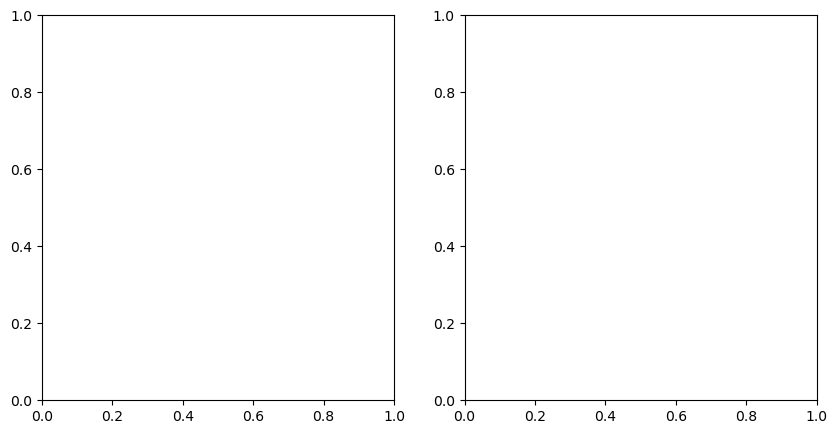

In [163]:
config = Configuration()
dataset = FistulaDataset(config, 'train')

sample = dataset[3]

image, label = sample['image'], sample['label']
# ! Rn, these have channel dimension. The below code does not expect that
# Convert the tensors to numpy arrays
image = image.numpy()
label = label.numpy()

seg_idx = 0
for i in range(label.shape[0]):
    if np.sum(label[i, :, :]) > 0:
        seg_idx = i
        break
print('seg_idx: ', seg_idx)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image[seg_idx + 2, :, :], cmap='gray')           # ! This is only showing the first slice
ax[0].set_title('Image')

ax[1].imshow(label[seg_idx + 2, :, :], cmap='gray')
ax[1].set_title('Label')

plt.show()

np.unique(label_np):  [0 1]
fraction of pixels that are 1:  0.002878202825670498
image size pre-resampling:  (290, 320, 72)
label size pre-resampling:  (290, 320, 72)
np.unique(label_resampled_np):  [0 1]
fraction of pixels that are 1:  0.000764171282450358
Label is binary
np.unique(label_resampled_np):  [0 1]
image size post-resampling:  (512, 512, 96)
label size post-resampling:  (512, 512, 96)
image tensor shape:  torch.Size([96, 512, 512])
label tensor shape:  torch.Size([96, 512, 512])
seg_idx:  30


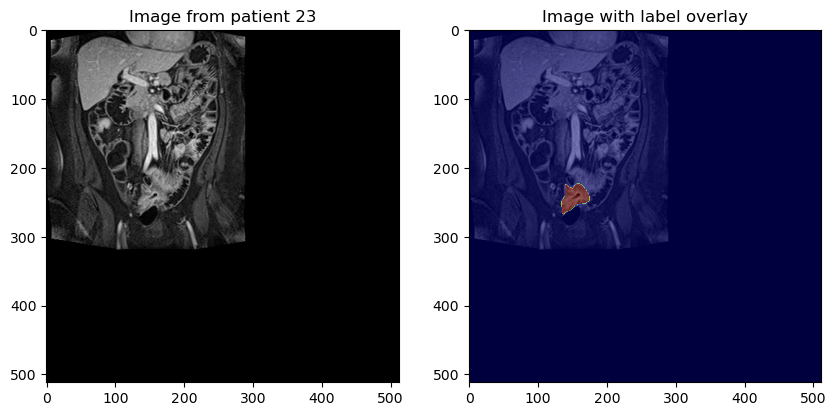

In [161]:
sample = dataset[0]

# Overlay the label on the image
image, label, patient_id = sample['image'], sample['label'], sample['patient_id']
# Convert the tensors to numpy arrays
image = image.numpy()
label = label.numpy()

seg_idx = 0
max_seg_pixels = 0
for i in range(label.shape[0]):
    if np.sum(label[i, :, :]) > max_seg_pixels:
        seg_idx = i
        max_seg_pixels = np.sum(label[i, :, :])
print('seg_idx: ', seg_idx)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show the image
ax[0].imshow(image[seg_idx, :, :], cmap='gray')
ax[0].set_title('Image from patient ' + str(patient_id))

# Overlay the label on the image
ax[1].imshow(image[seg_idx, :, :], cmap='gray')
ax[1].imshow(label[seg_idx, :, :], cmap='jet', alpha=0.5)
ax[1].set_title('Image with label overlay')

plt.savefig('/home/sasank/Documents/GitRepos/Fistula-Segmentation/dev_figs/patient_' + str(patient_id) + '.png')

plt.show()
